import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line


# Analysis

In [1]:
import warnings
from config import *
from functions import *
import pickle
sns.set(style="whitegrid")


Bad key "text.kerning_factor" on line 4 in
/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Analyzing Game Data in ways that can't be done with Tableau

### How many goals would be scored if every period was on the far side?

In [2]:
# import goal data 
goal_df = pd.read_csv("../data/goals.csv", index_col=0)

In [3]:
goal_df.describe()

,period,goal,game_id
count,19509.000000,19509.000000,1.950900e+04
mean,2.038546,1.500948,2.014164e+09
std,0.807395,0.747878,2.648608e+06
min,1.000000,1.000000,2.010020e+09
25%,1.000000,1.000000,2.012020e+09
50%,2.000000,1.000000,2.014021e+09
75%,3.000000,2.000000,2.017020e+09
max,3.000000,7.000000,2.018030e+09


#### Only 2nd period

In [4]:
# only 2nd period
goal_2nd_per = goal_df[goal_df['period'] == 2]
goal_2nd_per['goals_per_60'] = goal_2nd_per['goal'] * 3

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


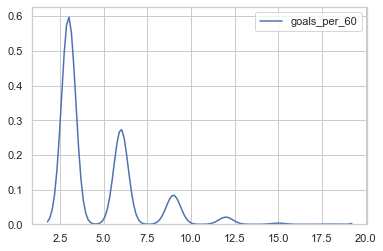

In [5]:
sns.kdeplot(goal_2nd_per['goals_per_60'])

In [6]:
# average num of goals
goal_2nd_per['goals_per_60'].mean()

4.596037261570309

#### Only 1st Period

In [7]:
goal_1st_per = goal_df[goal_df['period'] == 1]
goal_1st_per['goals_per_60'] = goal_1st_per['goal'] * 3

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


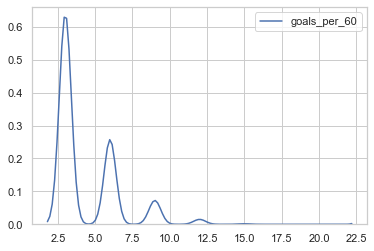

In [8]:
sns.kdeplot(goal_1st_per['goals_per_60'])

In [9]:
goal_1st_per['goals_per_60'].mean()

4.377688844422211

#### Average Number of Goals per Game per Year

In [10]:
goal_df.head(10)

,period,goal,game_id
0,3,1,2011030221
1,1,1,2011030111
2,2,1,2011030111
3,3,2,2011030111
4,3,2,2011030222
5,1,1,2011030223
6,3,1,2011030223
7,1,1,2011030224
8,3,1,2011030224
9,1,1,2011030225


In [11]:
test_game_id = goal_df['game_id'][0]

In [12]:
goal_df['season'] = goal_df['game_id'] // (10**6)

In [13]:
season_goals = goal_df.groupby(['season']).goal.mean() * 3
season_period_goals = goal_df.groupby(['season', 'period']).goal.mean()

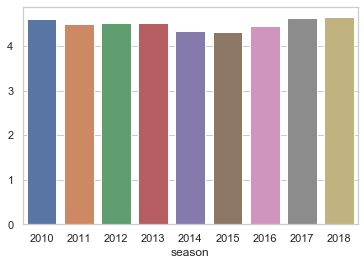

In [14]:
sns.barplot(x = season_goals.index, y = season_goals.values)

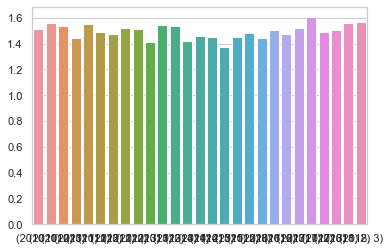

In [15]:
sns.barplot(x = season_period_goals.index, y = season_period_goals.values)

In [16]:
# viewing second period for each year 
goal_2nd_per['season'] = goal_2nd_per['game_id'] // (10**6)
season_2nd_period_goals = goal_2nd_per.groupby(['season']).goal.mean() 
season_2nd_period_goals_per_60 = goal_2nd_per.groupby(['season']).goal.mean() * 3

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


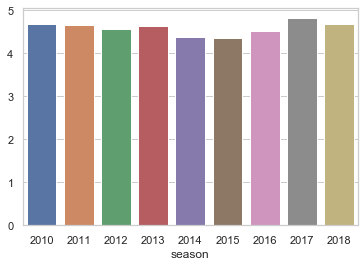

In [17]:
sns.barplot(x = season_2nd_period_goals_per_60.index, y= season_2nd_period_goals_per_60.values)

#### Increase in goals per year

In [18]:
increase_goals_w_long_change = season_2nd_period_goals_per_60.values - season_goals.values

In [19]:
increase_goals_w_long_change_rounded = [round(x, 2) for x in increase_goals_w_long_change]
increase_goals_w_long_change_rounded

[0.08, 0.16, 0.05, 0.13, 0.05, 0.03, 0.09, 0.2, 0.04]

In [20]:
increase_goals_w_long_change_rounded[0] * 12

0.96

In [21]:
sum (increase_goals_w_long_change_rounded) / len(increase_goals_w_long_change_rounded)

0.09222222222222223

In [22]:
# one more goal scored every 10.8 games
1 / 0.092

10.869565217391305

## Stoppages per game

In [23]:
stoppage_df = pd.read_csv("../data/stoppages.csv", index_col=0)
stoppage_avg = stoppage_df.groupby(['period']).Stoppage.mean()
stoppage_avg

period
1    7.547282
2    7.821321
3    7.665658
Name: Stoppage, dtype: float64

In [24]:
stoppages_proposals = generate_three_proposals(stoppage_avg)
stoppages_proposals

{'No_Change': 23.03, 'Two_Long_Changes': 23.31, 'Three_Long_Changes': 23.59}

In [25]:
stoppage_proposal_df = proposals_to_df(stoppages_proposals, "Stoppages")

## Takeaways

In [26]:
takeaways_df = pd.read_csv("../data/takeaways.csv", index_col=0)
takeaways_avg = takeaways_df.groupby(['period']).Takeaway.mean()

In [27]:
takeaways_avg

period
1    2.595429
2    2.479551
3    2.404253
Name: Takeaway, dtype: float64

In [28]:
takeaways_proposals = generate_three_proposals(takeaways_avg)
takeaways_proposals

{'No_Change': 7.48, 'Two_Long_Changes': 7.37, 'Three_Long_Changes': 7.26}

In [29]:
takeaway_df = proposals_to_df(takeaways_proposals, "Takeaways")

## Giveaways

In [30]:
giveaways_df = pd.read_csv("../data/giveaways.csv", index_col=0)
giveaways_avg = giveaways_df.groupby(['period']).Giveaway.mean()
giveaways_avg

period
1    3.108809
2    2.874962
3    2.690820
Name: Giveaway, dtype: float64

In [31]:
giveaways_proposals = generate_three_proposals(giveaways_avg)
giveaways_proposals

{'No_Change': 8.67, 'Two_Long_Changes': 8.47, 'Three_Long_Changes': 8.24}

In [32]:
giveaway_df = proposals_to_df(giveaways_proposals, "Giveaways")

## Hits

In [33]:
hit_avgs = get_category_and_period_avg('Hit')
hit_avgs

period
1    8.450547
2    7.119211
3    6.044054
Name: Hit, dtype: float64

In [34]:
hits_proposals = generate_three_proposals(hit_avgs)
hits_proposals

{'No_Change': 21.61, 'Two_Long_Changes': 20.66, 'Three_Long_Changes': 19.33}

In [35]:
hit_df = proposals_to_df(hits_proposals, "Hits")

## Penalties

In [36]:
penalties_df = pd.read_csv("../data/penalties.csv", index_col=0)
penalty_avgs = penalties_df.groupby(['period']).penalty.mean()
penalty_avgs

period
1    1.870265
2    2.009175
3    1.932623
Name: penalty, dtype: float64

In [37]:
penalties_proposals = generate_three_proposals(penalty_avgs)
penalties_proposals

{'No_Change': 5.81, 'Two_Long_Changes': 5.96, 'Three_Long_Changes': 6.09}

In [38]:
penalty_df = proposals_to_df(penalties_proposals, "Penalties")

### Do more penalties explain increase in goals

#### Penalty minute sums per period

In [39]:
# 5 on 4 play has 6.57 goals per 60, compared to 2.37 per 60 for 5 on 5
## number of penalty minutes per period
penalty_sums = penalties_df.groupby('period').penalty.sum()
penalty_sums_df = penalty_sums.to_frame()

In [40]:
penalty_sums_df['penalty_minutes'] = penalty_sums_df['penalty'] * 2

In [41]:
penalty_sums_df

,penalty,penalty_minutes
period,,
1,15454,30908
2,17518,35036
3,14514,29028


In [42]:
# expected goals from https://faculty.nps.edu/awashburn/docs/EstimatingNHLScoringRates.pdf
penalty_sums_df['expected_goals_added'] = (penalty_sums_df['penalty_minutes'] / 60) * 6.54

In [43]:
penalty_sums_df

,penalty,penalty_minutes,expected_goals_added
period,,,
1,15454,30908,3368.972
2,17518,35036,3818.924
3,14514,29028,3164.052


#### Goal sums per period

In [44]:
goals_df = pd.read_csv("../data/goals.csv",index_col=0)
goal_sums = goals_df.groupby('period').goal.sum()

In [45]:
goal_sums_df = goal_sums.to_frame()

goal_sums_df['expected_goals_added_by_pen'] = penalty_sums_df['expected_goals_added']

goal_sums_df['goals_minus_pen_goals_added'] = goal_sums_df['goal'] - goal_sums_df['expected_goals_added_by_pen']

In [46]:
# when you control for goals scored on powerplay, the third period has the most goals, followed by second, first
goal_sums_df

,goal,expected_goals_added_by_pen,goals_minus_pen_goals_added
period,,,
1,8751,3368.972,5382.028
2,10361,3818.924,6542.076
3,10170,3164.052,7005.948


## Shots

In [47]:
shots_df = pd.read_csv("../data/shots.csv", index_col=0)
shot_avgs = shots_df.groupby(['period']).shot.mean()
shot_avgs

period
1    8.527795
2    8.857232
3    8.059598
Name: shot, dtype: float64

In [48]:
shots_proposals = generate_three_proposals(shot_avgs)
shots_proposals

{'No_Change': 25.44, 'Two_Long_Changes': 25.76, 'Three_Long_Changes': 26.09}

In [49]:
shot_df = proposals_to_df(shots_proposals, "Shots")

## Blocked Shots

In [50]:
blocked_shots_df = pd.read_csv("../data/blocked_shots.csv", index_col=0)
blocked_shots_avgs = blocked_shots_df.groupby(['period'])['Blocked Shot'].mean()
blocked_shots_avgs

period
1    4.454365
2    4.437850
3    4.197767
Name: Blocked Shot, dtype: float64

In [51]:
blocked_shots_proposals = generate_three_proposals(blocked_shots_avgs)
blocked_shots_proposals

{'No_Change': 13.09, 'Two_Long_Changes': 13.07, 'Three_Long_Changes': 13.06}

In [52]:
blocked_shot_df = proposals_to_df(blocked_shots_proposals, "Blocked_Shots")

## Save Percentage

In [53]:
with open ("../data/save_pct_list", 'rb') as f:
    save_pct_list = pickle.load(f)

In [54]:
save_pct_list

[0.9087, 0.8959, 0.8878]

In [55]:
save_pct_df = pd.DataFrame(data = save_pct_list, columns = ["Save_Percentage"])
save_pct_df['Period'] = [1, 2, 3]

In [56]:
# save_pct_df.to_csv("../data/save_pct_df.csv")

## Goals

In [57]:
goals_df = pd.read_csv("../data/goals.csv",index_col=0)
goal_avgs = goals_df.groupby(['period']).goal.mean()
goal_avgs

period
1    1.459230
2    1.532012
3    1.506890
Name: goal, dtype: float64

In [58]:
goals_proposals = generate_three_proposals(goal_avgs)
goals_proposals

{'No_Change': 4.5, 'Two_Long_Changes': 4.57, 'Three_Long_Changes': 4.65}

In [59]:
goal_df = proposals_to_df(goals_proposals, "Goals")

## Shift Length

### All Positions

In [60]:
shifts_df = pd.read_csv("../data/all_positions_shifts.csv", header=None)

In [61]:
shifts_df.columns = ['period', 'shift_length', 'position', 'game_id']

In [62]:
shifts_avgs = shifts_df.groupby(['period', 'position']).shift_length.mean()
shifts_avgs

period  position
1       C           43.056593
        D           45.123369
        LW          43.322835
        RW          43.345602
2       C           46.336745
        D           49.971268
        LW          46.538081
        RW          46.609662
3       C           44.195191
        D           46.909917
        LW          44.446559
        RW          44.497024
Name: shift_length, dtype: float64

#### How many seconds longer are shifts in second period than 1st/3rd?

In [63]:
unstacked_shifts_avgs = shifts_avgs.unstack(level=1)

In [64]:
unstacked_shifts_avgs

position,C,D,LW,RW
period,,,,
1,43.056593,45.123369,43.322835,43.345602
2,46.336745,49.971268,46.538081,46.609662
3,44.195191,46.909917,44.446559,44.497024


In [65]:
mean_position_shifts = [sum(unstacked_shifts_avgs[x]) / len(unstacked_shifts_avgs[x]) 
                        for x in unstacked_shifts_avgs.columns]

In [66]:
mean_position_shifts

[44.529509477631116, 47.33485113026512, 44.769158528823205, 44.817429305181115]

In [67]:
unstacked_shifts_avgs.columns

Index(['C', 'D', 'LW', 'RW'], dtype='object', name='position')

In [68]:
diff_list = []
for col in unstacked_shifts_avgs.columns:
    first = unstacked_shifts_avgs[col].iloc[0]
    second = unstacked_shifts_avgs[col].iloc[1]
    diff = round(second - first, 2)
#     diff = second - first
    diff_list.append(diff)

In [69]:
diff_list

[3.28, 4.85, 3.22, 3.26]

#### What percent of shift length does this change represent?

In [70]:
percent_diff_in_second = [round(x/y, 2) 
                          for x,y in zip(diff_list, mean_position_shifts)]

In [71]:
percent_diff_in_second

[0.07, 0.1, 0.07, 0.07]

### Shift Length By Position and Side

In [72]:
# away LW and home RW are closer to bench for first and third periods
winger_shifts_post_2014 = pd.read_csv("../data/shift_length_by_position_home_or_away_post2014.csv", index_col=0)
winger_shift_avgs = winger_shifts_post_2014.groupby(['period', 'position', 'HoA']).shift_len.mean()
winger_shift_avgs

period  position  HoA 
1       LW        away    42.114057
                  home    42.960545
        RW        away    41.303775
                  home    42.223926
2       LW        away    46.541256
                  home    45.799587
        RW        away    45.185281
                  home    45.365118
3       LW        away    43.545211
                  home    43.445829
        RW        away    42.511462
                  home    43.117875
Name: shift_len, dtype: float64

In [73]:
home_close = winger_shift_avgs[1::2]

### Split data by closeness to bench 

In [74]:
winger_shift_avgs_df = winger_shift_avgs.unstack()

In [75]:
winger_shift_avgs_df['difference'] = winger_shift_avgs_df['away'] - winger_shift_avgs_df['home']

winger_shift_avgs_df['closer_to_bench'] = ['away', 'home' ,'home' ,'away', 'away',  'home']

winger_shift_avgs_df['expected'] = ['negative' if x == 'away' else 'positive'
                                    for x in winger_shift_avgs_df['closer_to_bench'] ]

# Combining Data For Proposals

In [76]:
proposals_df = pd.concat([stoppage_proposal_df, takeaway_df, giveaway_df, hit_df, shot_df, blocked_shot_df, goal_df, 
                          penalty_df],
                        axis = 1)

In [77]:
transposed_proposals_df = proposals_df.T
transposed_proposals_df.reset_index(inplace=True)
melted_proposals_df = transposed_proposals_df.melt(id_vars = ['index'])

In [91]:
# proposals_df.to_csv("../data/proposals_df.csv")

## Visualizing differences

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Change in Game Stats Based on Proposal Change')

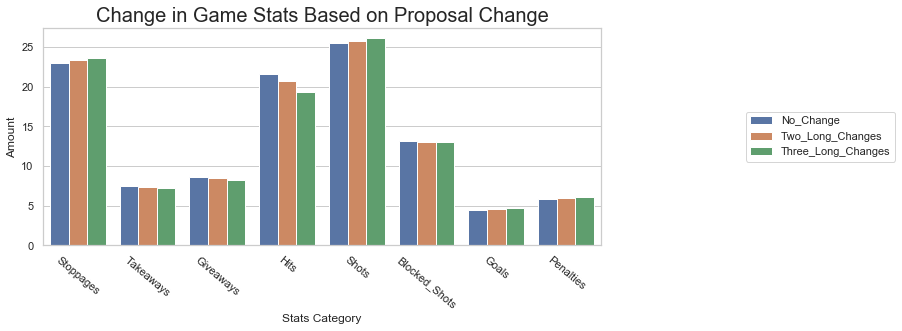

In [79]:
fig = plt.figure(figsize=(10, 4))
ax = sns.barplot(x = "index", y = 'value', hue = 'variable',
    data = melted_proposals_df)
ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.xticks(rotation=320)
plt.xlabel("Stats Category")
plt.ylabel("Amount")
plt.title("Change in Game Stats Based on Proposal Change", fontsize=20)


In [80]:
# fig.savefig("../images/Change in Game Stats Plot.png", bbox_inches = 'tight')

# Multiplying the third period effect into the proposal?

## Shots

In [81]:
#  Currently, the shots proposal is: 25.44, 26.24, 26.57
## with the 1st-3rd period effect added it will be  25.44, 25.75, 26.09
### so not a huge difference, but the effect of the proposal is dampened a bit 

In [82]:
shots_3_1_ratio = shot_avgs[3] / shot_avgs[1]

In [83]:
shots_2_change = shot_avgs[2] + shot_avgs[1] + (shot_avgs[2] * shots_3_1_ratio)
shots_2_change

25.7559746595712

In [84]:
shots_3_change = (shot_avgs[2] * 2) + (shot_avgs[2] * shots_3_1_ratio)
shots_3_change

26.085411396368258

## Goals

In [85]:
goal_avgs

period
1    1.459230
2    1.532012
3    1.506890
Name: goal, dtype: float64

In [86]:
goals_3_1_ratio = goal_avgs[3] / goal_avgs[1]

In [87]:
goals_2_change = goal_avgs[2] + goal_avgs[1] + (goal_avgs[2] * goals_3_1_ratio)
goals_2_change

4.573291929650052

In [88]:
goals_3_change = (goal_avgs[2] * 2) + (goal_avgs[2] * goals_3_1_ratio)
goals_3_change

4.646074735366085

In [89]:
proposals_df

,Stoppages,Takeaways,Giveaways,Hits,Shots,Blocked_Shots,Goals,Penalties
No_Change,23.03,7.48,8.67,21.61,25.44,13.09,4.50,5.81
Two_Long_Changes,23.31,7.37,8.47,20.66,25.76,13.07,4.57,5.96
Three_Long_Changes,23.59,7.26,8.24,19.33,26.09,13.06,4.65,6.09
